In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

In [2]:
weather_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
main_dir = os.path.abspath(os.path.join(weather_dir, os.pardir))

In [3]:
# Binning funcs from Huayi

def binMinute(minute):
    '''
    Calculate which of the 15min bins the current minute falls in.
    The bins are 05, 20, 35, 50. 
    Current minutes less than 05 belong to bin 50 of the hour before. 
    '''    
    m2q = (minute - 5) / 15
    if m2q < 0:
        newminute = -10 
    elif m2q < 1:
        newminute = 5
    elif m2q < 2:
        newminute = 20
    elif m2q < 3:
        newminute = 35
    elif m2q < 4:
        newminute = 50
    return newminute       
    
def BinTime(df_datetime_col):
    '''
    Take a df column that contains datetime object (df_datetime_col)
    Return a new column that contains the binned datetime object
    The bins are as defined in binMinute
    '''
    binned_col= df_datetime_col.apply(
        lambda x: x.replace(minute = 0, second = 0) + timedelta(minutes = binMinute(x.minute)))
    
    return binned_col

In [4]:
data_dir = os.path.join(weather_dir, 'test_data')

In [5]:
current_log = pd.read_csv(os.path.join(data_dir, 'current_log.csv'), index_col=0)

In [6]:
# convert unix times to datetimes
times_lst = ['reception_time', 'reference_time', 'sunrise_time', 'sunset_time']

tz_correct = 60 * 60 * 4

for col_n in ['reception_time', 'reference_time']:
    current_log[col_n] = pd.to_datetime(current_log[col_n], unit='s')

for col_n in ['sunrise_time', 'sunset_time']:
    current_log[col_n] = pd.to_datetime(current_log[col_n] - tz_correct, unit='s')


In [7]:
current_log['time_bin'] = BinTime(current_log['reception_time'])

binned_current_log = pd.concat(
    [current_log.groupby(['time_bin']).mean(),
     current_log.groupby(['time_bin']).max()[['park_name', 'sunrise_time', 'sunset_time', 'status', 'detailed_status']]],
    axis=1, sort=False)

# binned_current_log.to_csv(os.path.join(data_dir, 'binned_current_log.csv'))

(737518.3576388889, 737530.3472222222)

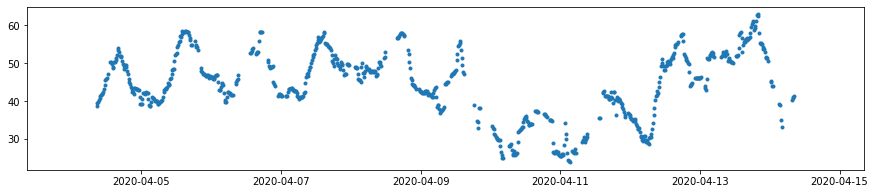

In [8]:
plt.figure(figsize=(15,3))

plt.scatter(binned_current_log.index, binned_current_log.temp_feels, marker='.')
# plt.scatter(binned_current_log.time[:100], bin_int_weather_hist.temperature[:100])
plt.xlim((min(binned_current_log.index)-timedelta(days=1), max(binned_current_log.index)+timedelta(days=1)))

In [9]:
start = min(binned_current_log.index)
end = max(binned_current_log.index)

num_bins = int(1 + (end - start) / timedelta(minutes=15))
t = np.linspace(start.value, end.value, num_bins)

all_bins = pd.DataFrame({'time_bin': pd.to_datetime(t)})

In [10]:
all_bins_df = all_bins.set_index('time_bin').join(binned_current_log)

In [11]:
interp_2nd = ['press', 'temp', 'temp_feels', 'temp_max', 'temp_min']

interp_1st = ['clouds', 'humidity']

interp_min = ['wind_speed', 'wind_deg']

for col in interp_1st:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=1, limit_direction ='forward')

for col in interp_2nd:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=2, limit_direction ='forward')

for col in interp_min:
    all_bins_df[col] = all_bins_df[col].interpolate(
        method='polynomial', order=1, limit_direction ='forward').clip(lower=0)

In [12]:
all_bins_df.columns

Index(['clouds', 'rain_1h', 'snow_1h', 'wind_speed', 'wind_deg', 'humidity',
       'press', 'temp', 'temp_feels', 'temp_max', 'temp_min', 'park_name',
       'sunrise_time', 'sunset_time', 'status', 'detailed_status'],
      dtype='object')

(737518.3576388889, 737530.3472222222)

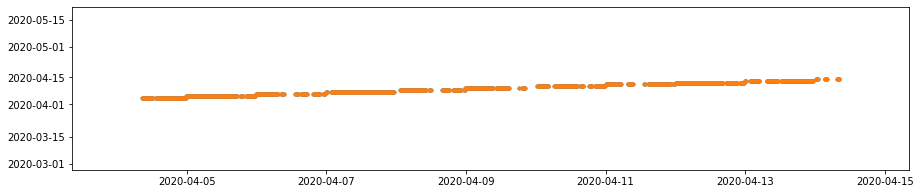

In [19]:
plot_col = 'sunrise_time'

plt.figure(figsize=(15,3))

plt.scatter(all_bins_df.index, all_bins_df[plot_col], marker='.')
plt.scatter(binned_current_log.index, binned_current_log[plot_col], marker='.')
plt.xlim((min(all_bins_df.index)-timedelta(days=1), max(all_bins_df.index)+timedelta(days=1)))

In [20]:
binned_current_log[['sunrise_time', 'sunset_time', 'clouds', 'rain_1h', 'snow_1h', 'wind_speed',
                    'humidity', 'press', 'temp_feels']]

,sunrise_time,sunset_time,clouds,rain_1h,snow_1h,wind_speed,humidity,press,temp_feels
time_bin,,,,,,,,,
2020-04-04 08:35:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.25,0.0,5.10,93.0,1016.0,38.700000
2020-04-04 08:50:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.25,0.0,4.60,93.0,1016.0,39.560000
2020-04-04 09:05:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.60,93.0,1016.0,39.670000
2020-04-04 09:20:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.35,93.0,1016.0,40.310000
2020-04-04 09:35:00,2020-04-04 06:33:33,2020-04-04 19:23:28,90.0,0.00,0.0,4.10,93.0,1016.0,40.750000
...,...,...,...,...,...,...,...,...,...
2020-04-14 04:05:00,2020-04-14 06:17:43,2020-04-14 19:33:52,40.0,0.00,0.0,9.30,53.0,1015.0,33.150000
2020-04-14 07:35:00,2020-04-14 06:17:43,2020-04-14 19:33:52,1.0,0.00,0.0,2.10,58.0,1017.0,40.390000
2020-04-14 07:50:00,2020-04-14 06:17:43,2020-04-14 19:33:52,1.0,0.00,0.0,2.10,58.0,1017.0,40.846667


In [11]:
(binned_current_log['sunset_time'] - binned_current_log['sunrise_time']) / 2

time_bin
2020-04-04 08:35:00   06:24:57.500000
2020-04-04 08:50:00   06:24:57.500000
2020-04-04 09:05:00   06:24:57.500000
2020-04-04 09:20:00   06:24:57.500000
2020-04-04 09:35:00   06:24:57.500000
                            ...      
2020-04-14 04:05:00   06:38:04.500000
2020-04-14 07:35:00   06:38:04.500000
2020-04-14 07:50:00   06:38:04.500000
2020-04-14 08:05:00   06:38:04.500000
2020-04-14 08:20:00   06:38:04.500000
Length: 750, dtype: timedelta64[ns]

In [12]:
binned_current_log['peak_time'] = binned_current_log['sunrise_time'] + (binned_current_log['sunset_time'] - binned_current_log['sunrise_time']) / 2

In [13]:
(binned_current_log['peak_time'] - binned_current_log.index)[40:80]


time_bin
2020-04-04 19:20:00   -1 days +17:38:30.500000
2020-04-04 19:35:00   -1 days +17:23:30.500000
2020-04-04 19:50:00   -1 days +17:08:30.500000
2020-04-04 20:05:00   -1 days +16:53:30.500000
2020-04-04 20:20:00   -1 days +16:38:30.500000
2020-04-04 20:35:00   -1 days +16:23:30.500000
2020-04-04 20:50:00   -1 days +16:08:30.500000
2020-04-04 21:05:00   -1 days +15:53:30.500000
2020-04-04 21:20:00   -1 days +15:38:30.500000
2020-04-04 21:35:00   -1 days +15:23:30.500000
2020-04-04 21:50:00   -1 days +15:08:30.500000
2020-04-04 22:05:00   -1 days +14:53:30.500000
2020-04-04 22:20:00   -1 days +14:38:30.500000
2020-04-04 22:35:00   -1 days +14:23:30.500000
2020-04-04 22:50:00   -1 days +14:08:30.500000
2020-04-04 23:05:00   -1 days +13:53:30.500000
2020-04-04 23:20:00   -1 days +13:38:30.500000
2020-04-04 23:35:00   -1 days +13:23:30.500000
2020-04-04 23:50:00                   13:08:13
2020-04-05 00:05:00                   12:53:13
2020-04-05 00:20:00                   12:38:13
2020